In [2]:
import sys
import time
import numpy as np
import numba as nb
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [3]:
PathWindows = r"D:\Учеба\Практика\Диплом\gamma"
LibraryPathWindows = r"D:\Учеба\Практика\Диплом\gamma\SpectrumsMeasurementsLibrary"
LibraryPathLinux = r"/home/danis/work/python_works/gamma"
sys.path.insert(0, LibraryPathWindows)
sys.path.insert(0, PathWindows)
sys.path.insert(0, LibraryPathLinux)

In [4]:
from GammaRayInteractions.Materials import Material, R
from CrossSectionsLibrary.cross_sections_data import ENERGY_MESH
from MeasurementInstrumentation.measurement_techniques import ideal_transmission_function, \
k_edge_method_transmission_function, ross_method_transmission_function, edges_indices, open_detector
from NumericalMethods.simpson_rule import simpson_rule
from NumericalMethods.unfolding_technique import Gold

import matplotlib.ticker as mticker
from local_scripts import initialization_brem, generate_empty_matrix, complete_empty_matrix, integrate_the_row, get_integral_signals, apply_function_to_matrix

In [38]:
font_properties = {'family' : 'Arial', 'weight' : 'regular', 'size' : 16}
rc('font', **font_properties)

Инициализация энергетического спектра

In [6]:
beam_energy = 0.075
z_number = 50

In [7]:
brem = initialization_brem(z_number, beam_energy)

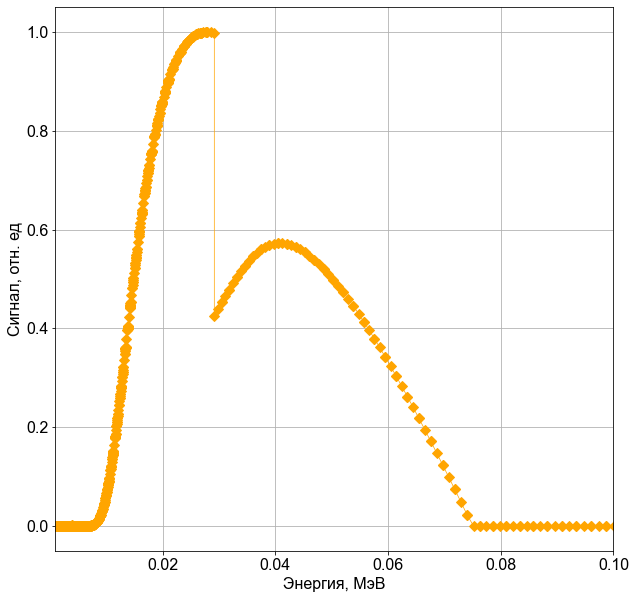

In [39]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(ENERGY_MESH, brem, ls='-', marker='D', lw='0.7', ms=7, color='orange')

# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Сигнал, отн. ед')
ax.tick_params(axis='both')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 1e-1)
# ax.set_ylim(1e-15, 1.2)
ax.grid(True)

Инициализация измерительных каналов

In [9]:
first_channel = 11
last_channel = 100 
number_of_channels = last_channel - first_channel + 1

In [241]:
level = 0.3

In [243]:
# создание измерительных каналов
ROSS_METHOD_channels = [ross_method_transmission_function(num, num+1, level) for num in range(first_channel, last_channel)]
# создание канала с открытым детектором
channel_with_open_detector = open_detector()
# добавление канала с открытым детектором
# ROSS_METHOD_channels.insert(0, channel_with_open_detector)

In [244]:
K = np.array(ROSS_METHOD_channels)

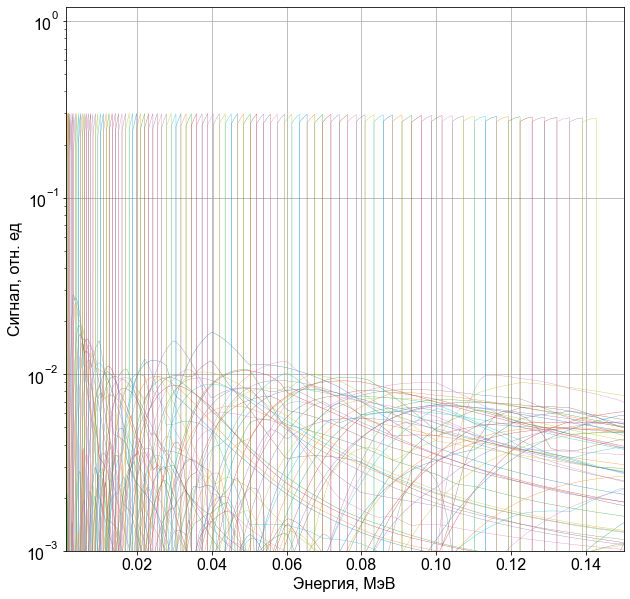

In [245]:
number_of_signals = fig, ax = plt.subplots(figsize=(10, 10))
for i in ROSS_METHOD_channels:
    ax.plot(ENERGY_MESH, i, ls='-', lw='0.3', ms=5)

# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Сигнал, отн. ед')
ax.tick_params(axis='both')
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-3, 1.5e-1)
ax.set_ylim(1e-3, 1.2)
ax.grid(True)

In [268]:
ROSS_METHOD_channels_f = [ross_method_transmission_function(num, num+1, level, regime='first') 
                          for num in range(first_channel, last_channel)]

In [269]:
ROSS_METHOD_channels_s = [ross_method_transmission_function(num, num+1, level, regime='second') 
                          for num in range(first_channel, last_channel)]

Создание матрицы с измерительной системы

In [248]:
# создание матрицы задачи
matrix = np.array([simpson_rule(r, regime='c', function_jumps=[Material(50).k_edge_index()]) for r in ROSS_METHOD_channels])
new_mesh = np.array(simpson_rule(ROSS_METHOD_channels[0], regime='m', function_jumps=[Material(50).k_edge_index()]))

In [249]:
matrix_f = np.array([simpson_rule(r, regime='c', function_jumps=[Material(50).k_edge_index()]) for r in ROSS_METHOD_channels_f])
matrix_s = np.array([simpson_rule(r, regime='c', function_jumps=[Material(50).k_edge_index()]) for r in ROSS_METHOD_channels_s]) # создание матрицы одной системы

Измерение энергетического спектра

In [250]:
# вычисление среднего значение энергии в полосах пропускания измерительных каналов
left_bounds = [Material(i).k_edge_energy() for i in range(11, 99)]
right_bounds = [Material(i).k_edge_energy() for i in range(12, 100)]
mean_energy_in_pass_band = [(val2 + val1) / 2 for val1, val2 in zip(left_bounds, right_bounds)]

delta = [val2 - val1 for val1, val2 in zip(left_bounds, right_bounds)]

In [251]:
signals = np.array([simpson_rule(r*brem) for r in ROSS_METHOD_channels])
signals_f = np.array([simpson_rule(r*brem) for r in ROSS_METHOD_channels_f])
signals_s = np.array([simpson_rule(r*brem) for r in ROSS_METHOD_channels_s])

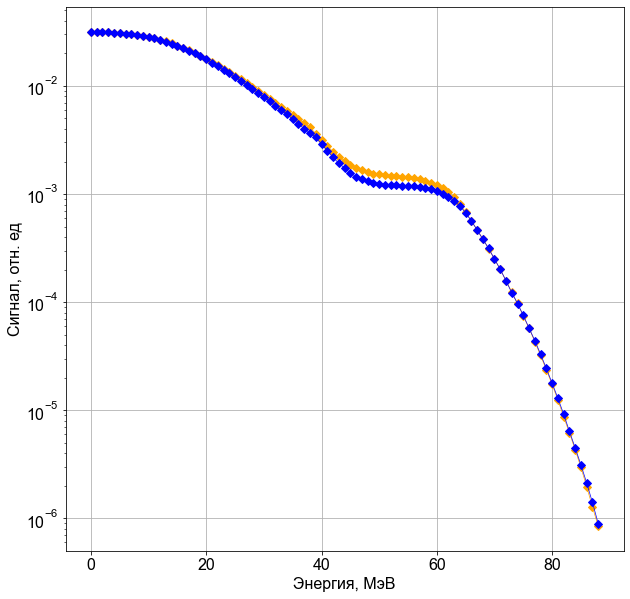

In [252]:
number_of_signals = len(ROSS_METHOD_channels)
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(range(len(signals)), signals_s, ls='-', marker='D', lw='0.7', ms=5, color='orange')
ax.plot(range(len(signals)), signals_f, ls='-', marker='D', lw='0.7', ms=5, color='blue')

# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Сигнал, отн. ед')
ax.tick_params(axis='both')
# ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim(1e-3, 1e+2)
# ax.set_ylim(1e-15, 1.2)
ax.grid(True)

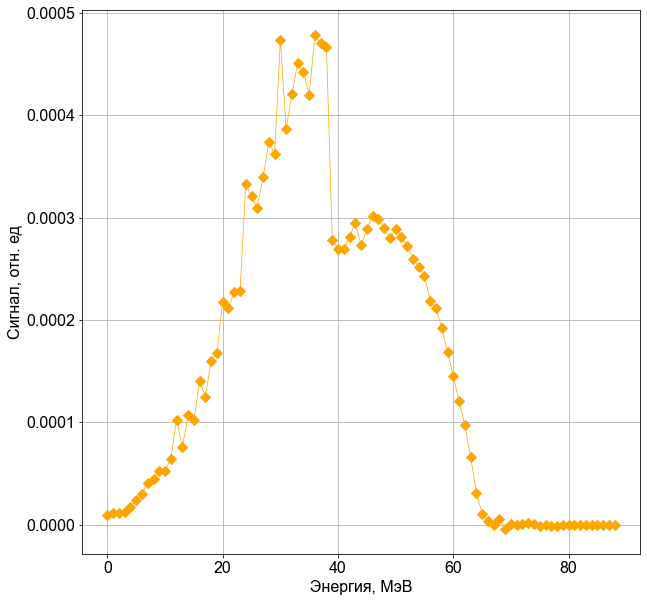

In [253]:
number_of_signals = len(ROSS_METHOD_channels)
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(range(len(signals)), signals, ls='-', marker='D', lw='0.7', ms=7, color='orange')

# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Сигнал, отн. ед')
ax.tick_params(axis='both')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(1e-3, 1e-1)
# ax.set_ylim(1e-15, 1.2)
ax.grid(True)

Восстановление спектра

In [254]:
bound_100_kev = Material(100).k_edge_index()

In [255]:
result = Gold(matrix, signals, 0, ENERGY_MESH, new_mesh, brem, iteration_number=10000, bound=bound_100_kev, journal=False, weight_mode='channel')

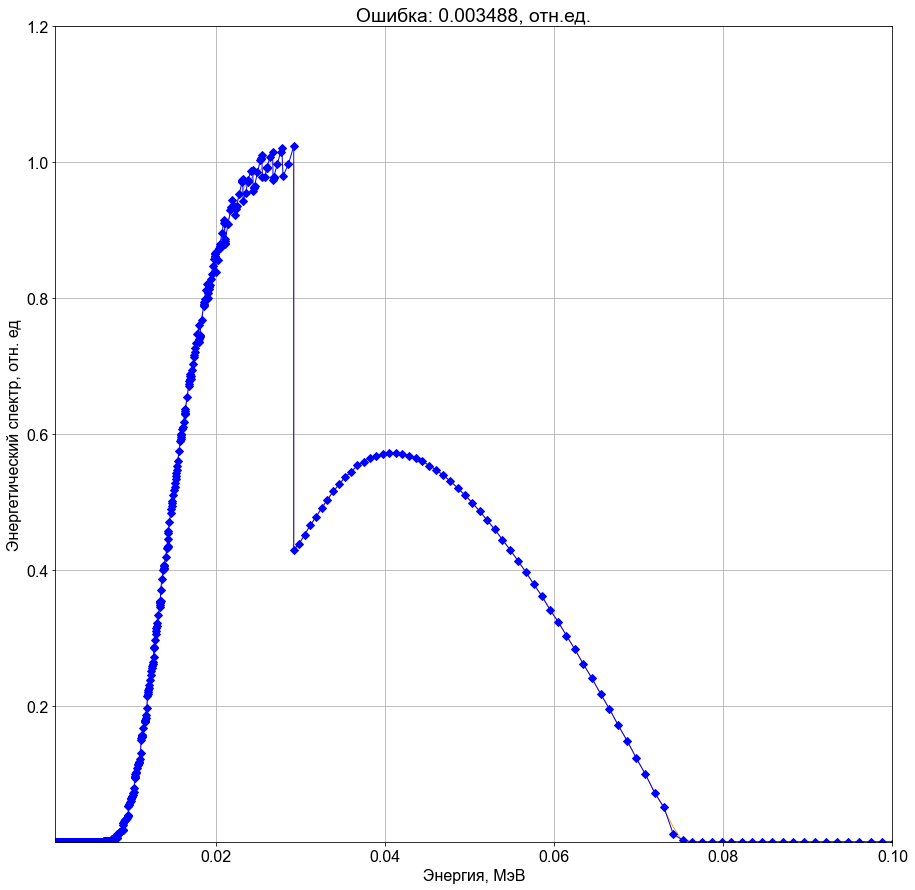

In [256]:
fig, ax = plt.subplots(figsize=(15, 15))

ax.plot(ENERGY_MESH, brem, ls='-', lw='1', ms=5, color='orange')
ax.plot(new_mesh, result[0], ls='-', lw='1', marker='D', ms=5, color='blue')


# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Энергетический спектр, отн. ед')
ax.tick_params(axis='both')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 0.1e0)
ax.set_ylim(1e-7, 1.2)

ax.set_title(f'Ошибка: {round(result[1], 6)}, отн.ед.')

ax.grid(True)

In [262]:
np.linalg.cond(matrix)

168.68853132668343

Совместное использование вычетных и опорных сигналов

In [257]:
signals_both = np.hstack((signals_f, signals_s))

In [258]:
matrix_both = np.vstack((matrix_f, matrix_s))

In [230]:
matrix_both.shape

(178, 1438)

In [265]:
result_both = Gold(matrix_both, signals_both, -1, ENERGY_MESH, new_mesh, brem, iteration_number=10000, bound=bound_100_kev, journal=False, weight_mode='value')

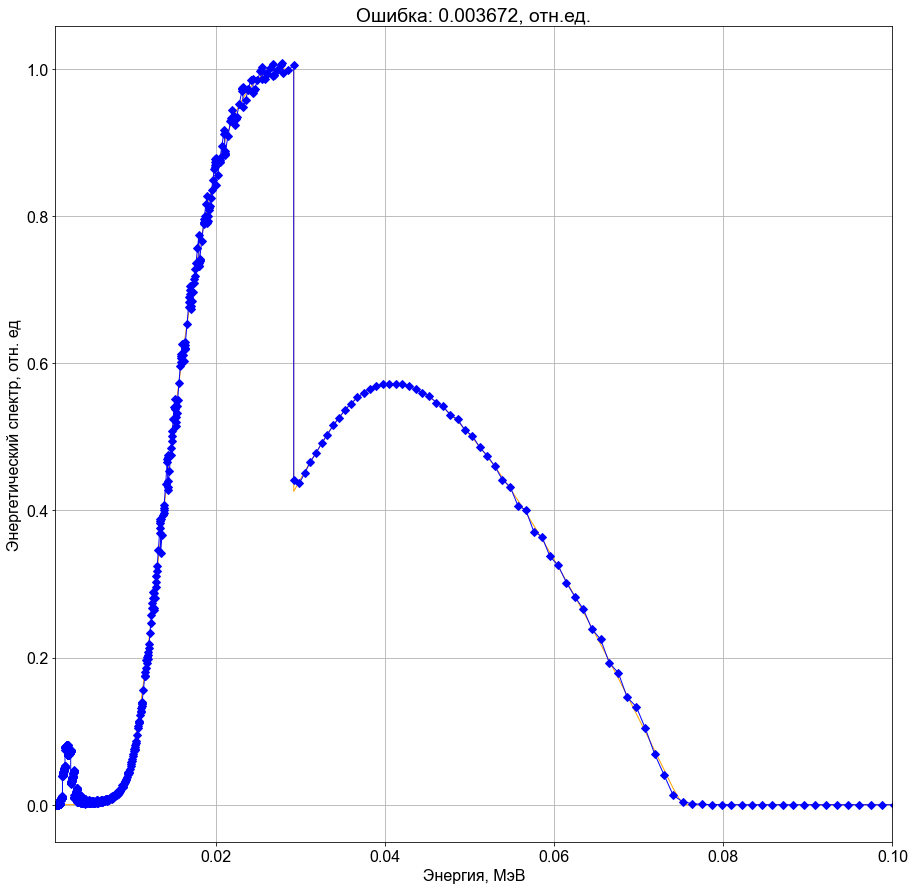

In [266]:
fig, ax = plt.subplots(figsize=(15, 15))

ax.plot(ENERGY_MESH, brem, ls='-', lw='1', ms=5, color='orange')
ax.plot(new_mesh, result_both[0], ls='-', lw='1', marker='D', ms=5, color='blue')


# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Энергетический спектр, отн. ед')
ax.tick_params(axis='both')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 0.1e0)
# ax.set_ylim(1e-7, 1.2)

ax.set_title(f'Ошибка: {round(result_both[1], 6)}, отн.ед.')

ax.grid(True)

In [267]:
np.linalg.cond(matrix_both)

6419770.629205039

Идеальные полосы пропускания

In [139]:
IDEAL_channels = [ideal_transmission_function(num, num+1, level) for num in range(first_channel, last_channel)]

In [140]:
ideal_signals = np.array([simpson_rule(r*brem) for r in IDEAL_channels])

In [167]:
left_bounds = [Material(i).k_edge_energy() for i in range(11, 99)]
right_bounds = [Material(i).k_edge_energy() for i in range(12, 100)]
mean_energy_in_pass_band = [(val2 + val1) / 2 for val1, val2 in zip(left_bounds, right_bounds)]

In [168]:
delta = [val2 - val1 for val1, val2 in zip(left_bounds, right_bounds)]

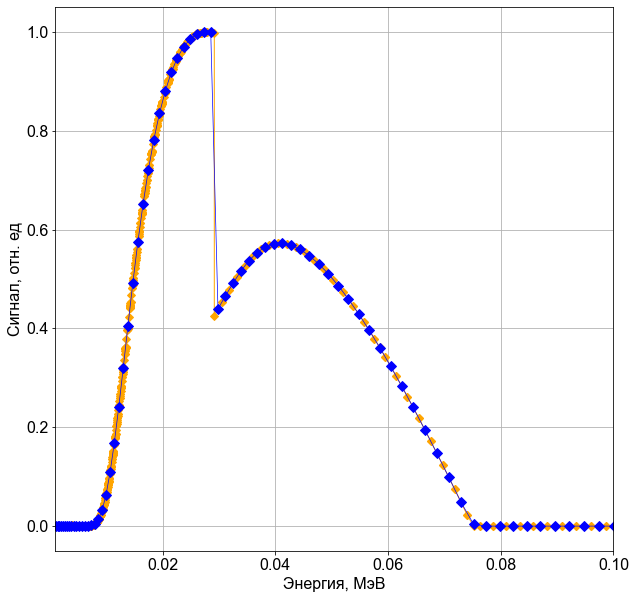

In [169]:
number_of_signals = len(ROSS_METHOD_channels)
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(ENERGY_MESH, brem, ls='-', lw='1', marker='D', ms=5, color='orange')
ax.plot(mean_energy_in_pass_band, ideal_signals[:-1]/delta/level, ls='-', marker='D', lw='0.7', ms=7, color='blue')

# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Сигнал, отн. ед')
ax.tick_params(axis='both')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 1e-1)
# ax.set_ylim(1e-15, 1.2)
ax.grid(True)

Сохранение эксель файлов

In [220]:
from xlsxwriter.workbook import Workbook

workbook = Workbook("спектр3.xlsx")
worksheet = workbook.add_worksheet('Лист1')

worksheet.write_column(5, 4, cc)
worksheet.write_column(5, 5, signals_ff)
worksheet.write_column(5, 6, signals_ss)


workbook.close()

In [219]:
signals_ff = np.array([simpson_rule(r*brem) for r in a])
signals_ss = np.array([simpson_rule(r*brem) for r in b])
cc = np.array([simpson_rule(r*brem) for r in c])

Сохранение результатов

In [160]:
# K_EDGE_METHOD_SIGNALS = np.save('СИГНАЛЫ_К_пропускание_08.npy', SIGNALS)